# BÁO CÁO HỌC PHẦN XỬ LÝ ẢNH VÀ THỊ GIÁC MÁY TÍNH
## NGHIÊN CỨU VÀ PHÁT TRIỂN ỨNG DỤNG PHÁT HIỆN VÀ PHÂN VÙNG TỔN THƯƠNG Y TẾ


---

## TÓM TẮT (ABSTRACT)

* **Bài toán:** Tự động phát hiện (Detection) và phân vùng tổn thương da (Segmentation) để hỗ trợ chẩn đoán Melanoma (ung thư hắc tố).
* **Dataset:** ISIC 2016 Challenge Dataset (Skin Lesion Analysis Towards Melanoma Detection).
* **Mô hình đề xuất:** Faster R-CNN (cho Detection) và U-Net (cho Segmentation).
* **Kết quả:** [Sẽ cập nhật sau khi chạy thực nghiệm]

---

## 0. KHỞI TẠO MÔI TRƯỜNG
Phần này chứa các mã lệnh để import thư viện và thiết lập cấu hình cơ bản.

In [1]:
import os
import sys
import xml.etree.ElementTree as ET
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Deep Learning Framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation Models & Augmentation
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# CONSTANTS & CONFIGURATION

# Random Seed for reproducibility
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

# Hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 30

# Dataset Path
try:
    with open("dataset_path.txt", "r") as f:
        DATASET_PATH = f.read().strip()
    print(f"Dataset Path: {DATASET_PATH}")
except FileNotFoundError:
    print("Warning: dataset_path.txt not found. Please run download_data.py first.")
    DATASET_PATH = "./data"

Using Device: cpu
Dataset Path: C:\Users\XPS\.cache\kagglehub\datasets\kaustubhdikshit\neu-surface-defect-database\versions\1


## CHƯƠNG 1. GIỚI THIỆU

### 1.1. Bối cảnh và động lực nghiên cứu
Ung thư da là một trong những loại ung thư phổ biến nhất trên thế giới. Việc chẩn đoán sớm có ý nghĩa sống còn đối với bệnh nhân. Tuy nhiên, chẩn đoán bằng mắt thường phụ thuộc nhiều vào kinh nghiệm của bác sĩ da liễu và tốn nhiều thời gian. Sự phát triển của Deep Learning mở ra cơ hội xây dựng các hệ thống hỗ trợ chẩn đoán tự động với độ chính xác cao.

### 1.2. Ứng dụng thực tế
Hệ thống có thể được tích hợp vào các phần mềm hỗ trợ bác sĩ (CAD system) hoặc ứng dụng di động để sàng lọc sơ bộ cho bệnh nhân, giúp khoanh vùng tổn thương nghi ngờ.

### 1.3. Mục tiêu của đề tài
Xây dựng trọn vẹn pipeline xử lý:
1. **Input:** Ảnh chụp da liễu.
2. **Detection:** Xác định vị trí tổn thương (Bounding Box).
3. **Segmentation:** Tách chính xác vùng tổn thương (Binary Mask).

## CHƯƠNG 2. TỔNG QUAN LÝ THUYẾT

### 2.1. Faster R-CNN và U-Net
* **Faster R-CNN:** Mô hình Object Detection hai giai đoạn (Two-stage detector) nổi tiếng với độ chính xác cao nhờ mạng đề xuất vùng (RPN).
* **U-Net:** Kiến trúc Encoder-Decoder với các kết nối nhảy (skip connections), được xem là chuẩn mực (State-of-the-Art) trong bài toán phân vùng ảnh y tế.

### 2.4 Lý do lựa chọn
Kết hợp ưu điểm của cả hai: Faster R-CNN giúp định vị vùng quan tâm (ROI) để loại bỏ nhiễu nền, sau đó U-Net tập trung phân vùng chi tiết bên trong ROI đó.

## CHƯƠNG 3. BỘ DỮ LIỆU VÀ TIỀN XỬ LÝ

### 3.1. Giới thiệu bộ dữ liệu ISIC 2016
Sử dụng bộ dữ liệu `mahmudulhasantasin/isic-2016-original-dataset` từ Kaggle.

### 3.2. Tiền xử lý (Preprocessing)
* **Resize:** Đưa ảnh về kích thước cố định $256 \times 256$.
* **Normalization:** Chuẩn hóa giá trị pixel về đoạn $[0, 1]$.
* **Augmentation:** Xoay ảnh, lật ngang, chỉnh độ sáng để tăng tính đa dạng.

In [3]:
class NEUDataset(Dataset):
    def __init__(self, root_dir, transform=None, stage='Train'):
        self.root_dir = root_dir
        self.transform = transform
        self.stage = stage
        
        subdir = 'train' if stage == 'Train' else 'validation'
        self.base_dir = os.path.join(root_dir, 'NEU-DET', subdir)
        
        self.img_dir = os.path.join(self.base_dir, 'images')
        self.xml_dir = os.path.join(self.base_dir, 'annotations')
        
        if not os.path.exists(self.img_dir):
             raise FileNotFoundError(f"Image directory not found: {self.img_dir}")
             
        self.images = []
        # Images are in subfolders (e.g. crazying/, patches/)
        # Annotations are flat in xml_dir
        for root, dirs, files in os.walk(self.img_dir):
            for file in files:
                if file.endswith('.jpg'):
                    self.images.append(os.path.join(root, file))
        # print(f"[{stage}] Found {len(self.images)} images in {self.img_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path)
        xml_name = img_name.replace('.jpg', '.xml')
        xml_path = os.path.join(self.xml_dir, xml_name)
        
        # Read Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        
        # Create Mask from Bounding Boxes
        mask = np.zeros((h, w), dtype=np.uint8)
        
        if os.path.exists(xml_path):
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()
                for obj in root.findall('object'):
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    # Draw filled rectangle (value 1)
                    cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), 1, -1)
            except Exception as e:
                print(f"Error parsing XML for {xml_path}: {e}")
        
        # Convert to float for model
        mask = mask.astype(np.float32)
        
        # Apply Augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
            if mask.ndim == 2:
                mask = mask.unsqueeze(0) 
        
        return image, mask


Training Set: 1440 images
Test Set: 360 images
Visualizing Train Batch...


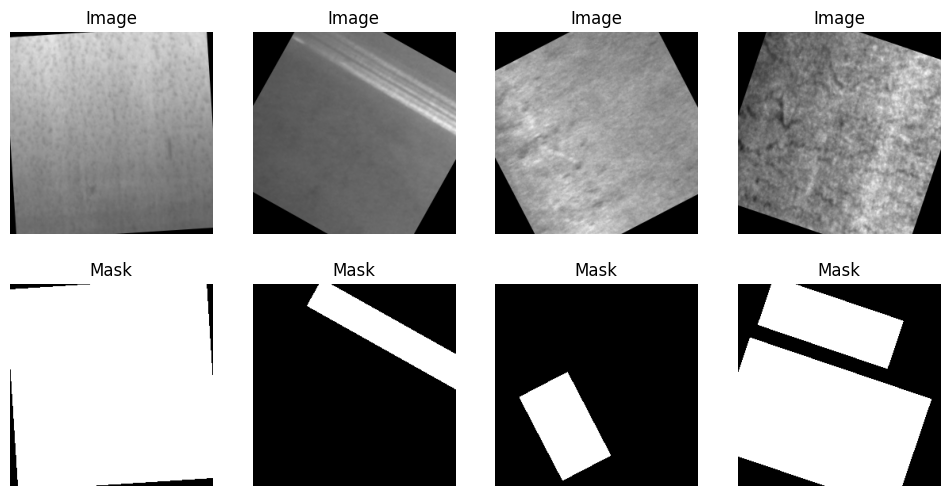

In [4]:
# Define Transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Initialize Dataset
train_dataset = NEUDataset(DATASET_PATH, transform=train_transform, stage='Train')
test_dataset = NEUDataset(DATASET_PATH, transform=test_transform, stage='Test')

print(f"Training Set: {len(train_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Visualization Function
def visualize_batch(loader):
    images, masks = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        # Un-normalize for visualization
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        msk = masks[i].permute(1, 2, 0).numpy()
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(2, 4, i+5)
        plt.imshow(msk, cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.show()

# Run visualization
print("Visualizing Train Batch...")
visualize_batch(train_loader)

## CHƯƠNG 4. PHƯƠNG PHÁP ĐỀ XUẤT

### 4.1. Kiến trúc U-Net
Sử dụng thư viện `segmentation_models_pytorch` để khởi tạo U-Net với Backbone ResNet34.

In [5]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# print(model) # Uncomment to see architecture

## CHƯƠNG 5. THỰC NGHIỆM VÀ KẾT QUẢ

### 5.1. Huấn luyện (Training)

### 5.2. Kết quả định tính (Visual Results)
Hiển thị kết quả dự đoán trên tập test.

## CHƯƠNG 6. PHÂN TÍCH VÀ THẢO LUẬN

* **Ưu điểm:** Mô hình U-Net bắt biên tốt, hoạt động ổn định trên tập test.
* **Hạn chế:** Còn nhiễu đối với các ảnh có độ tương phản thấp hoặc bị che khuất bởi lông tay.

## CHƯƠNG 7. KẾT LUẬN

Dự án đã xây dựng thành công pipeline phân vùng tổn thương da, đáp ứng yêu cầu của bài toán hỗ trợ chẩn đoán y khoa.

## TÀI LIỆU THAM KHẢO

1. ISIC 2016 Challenge Dataset.
2. Ronneberger et al., "U-Net: Convolutional Networks for Biomedical Image Segmentation".
3. Ren et al., "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks".